Download package at the first time

In [1]:
# pip install torch
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install scipy
# pip install scikit-learn

Expermental data classification

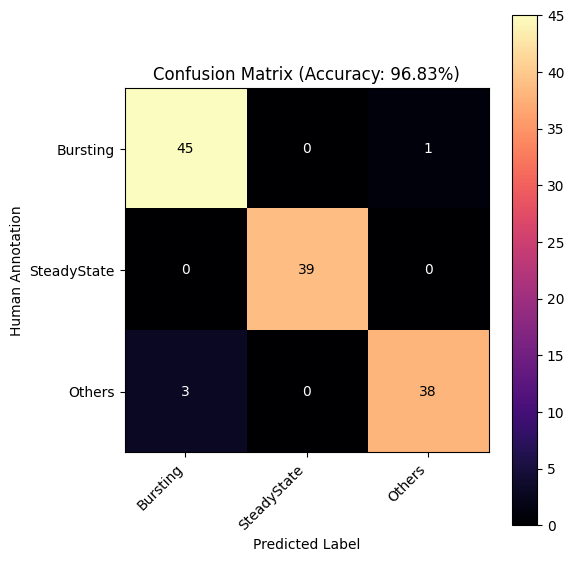

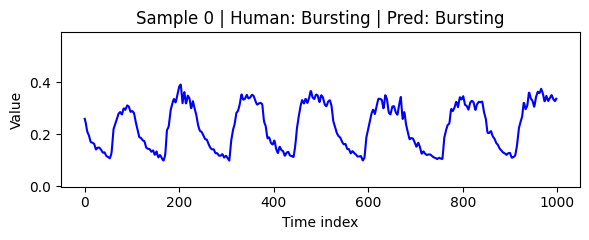

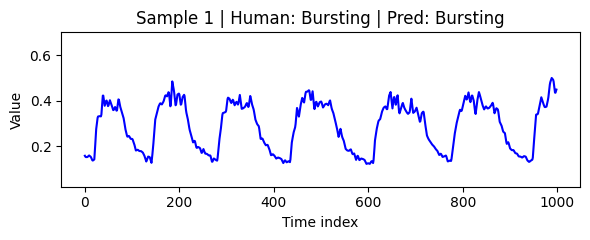

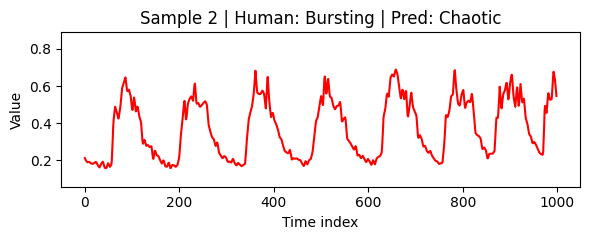

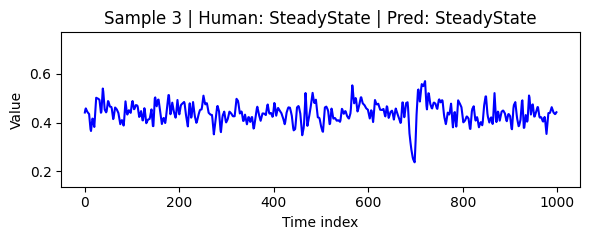

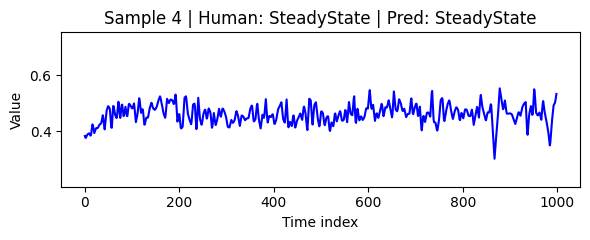

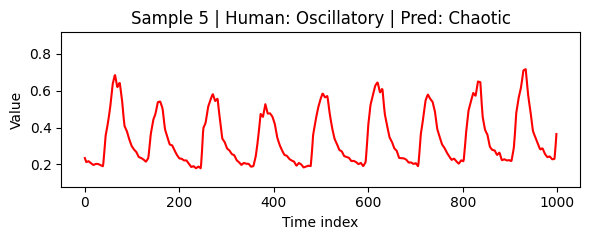

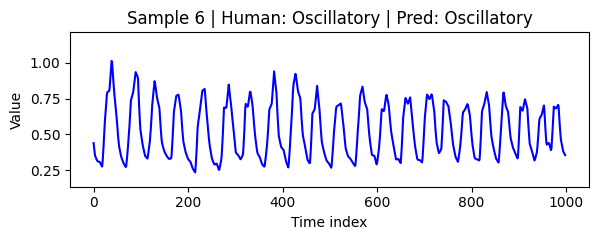

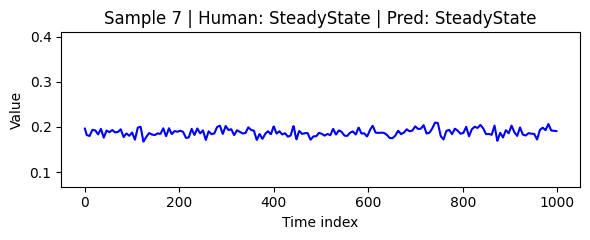

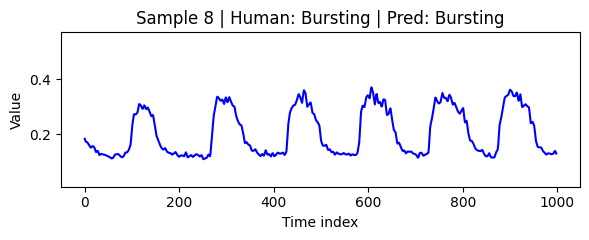

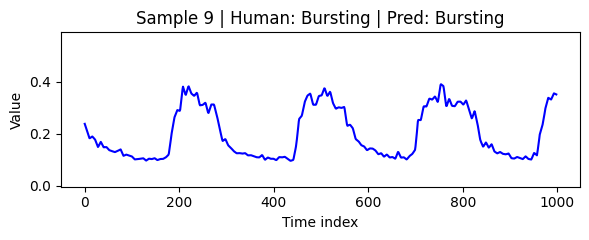

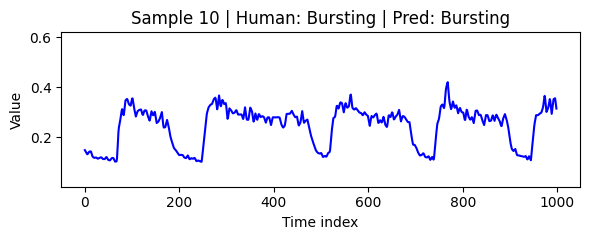

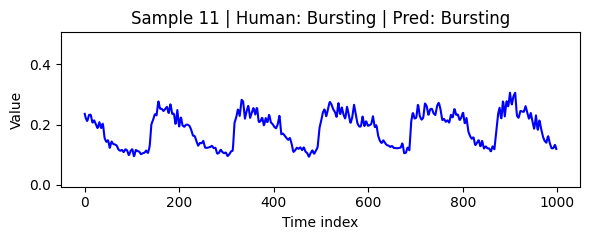

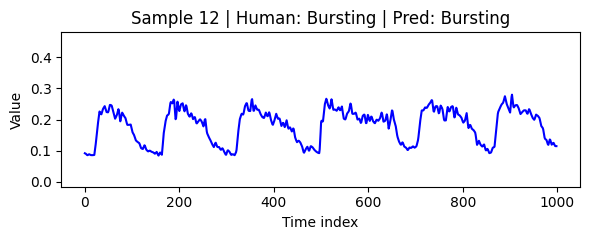

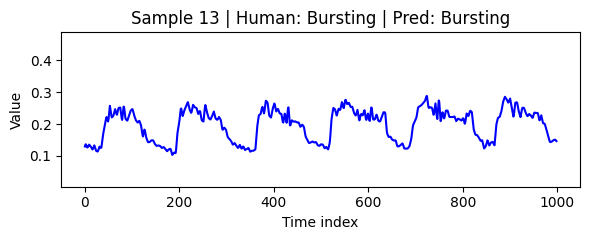

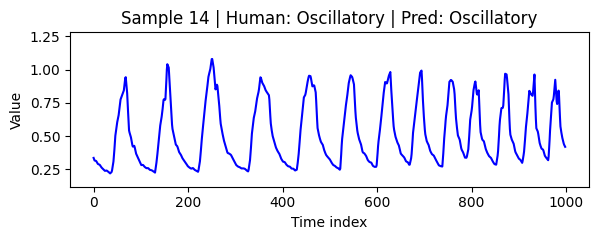

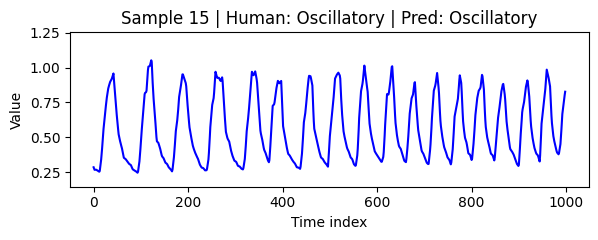

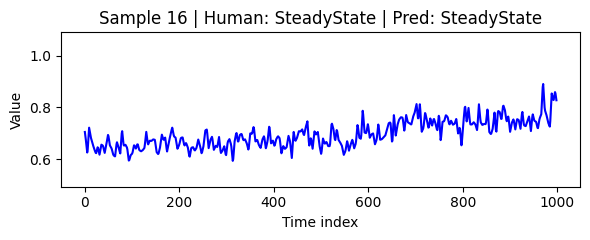

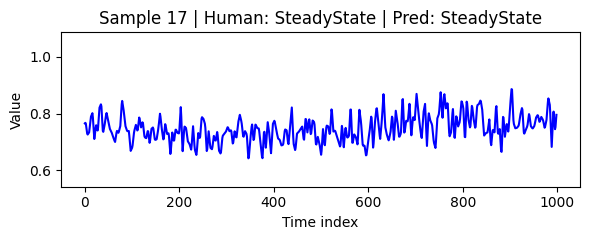

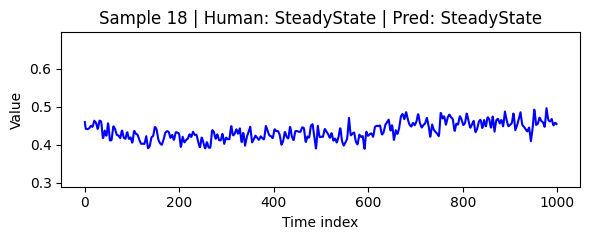

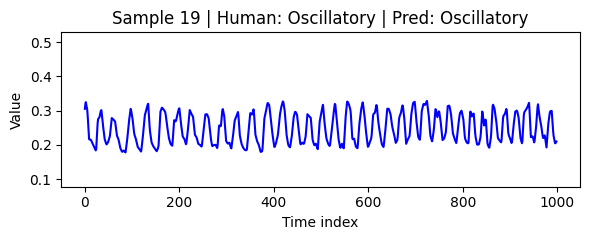

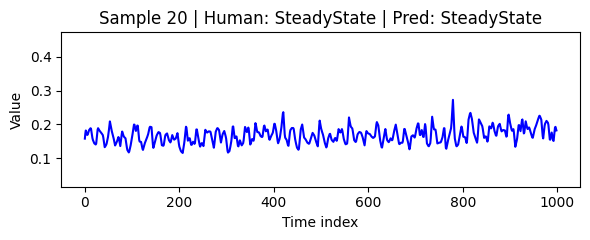

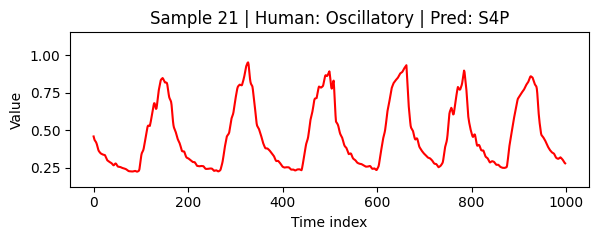

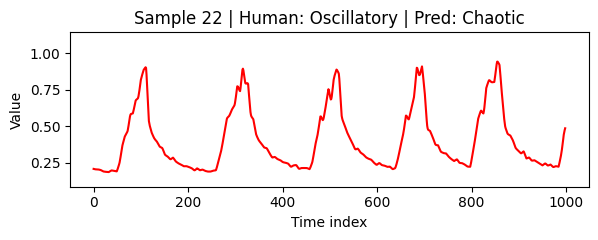

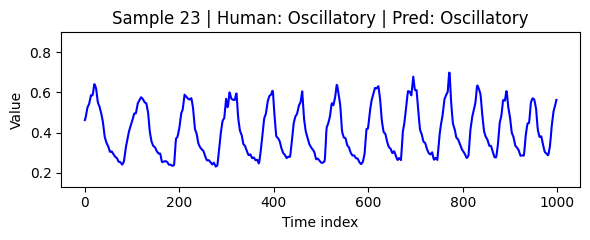

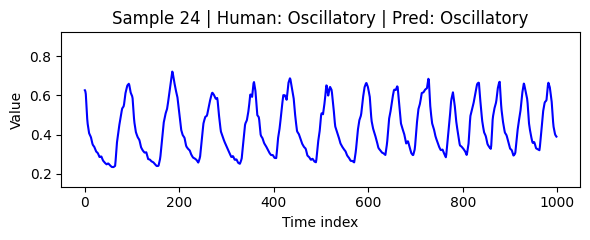

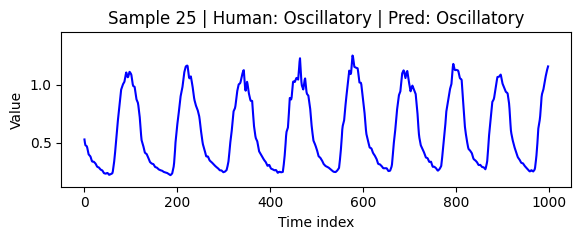

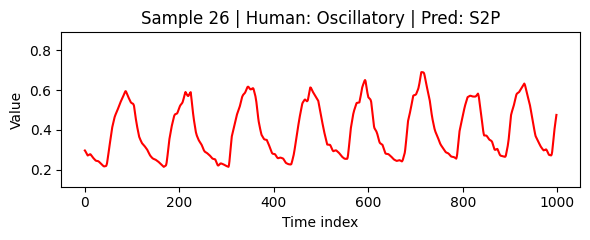

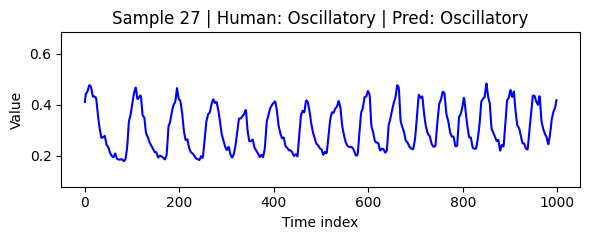

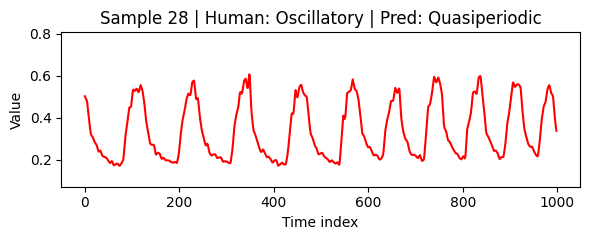

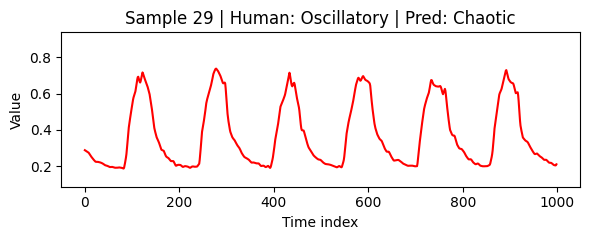

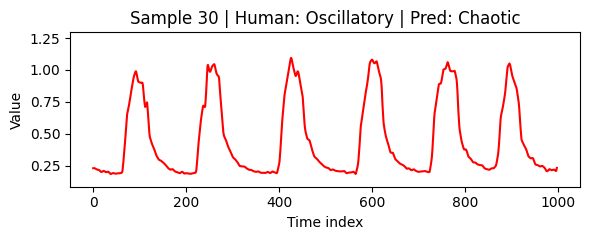

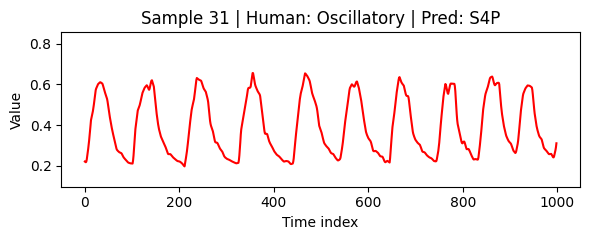

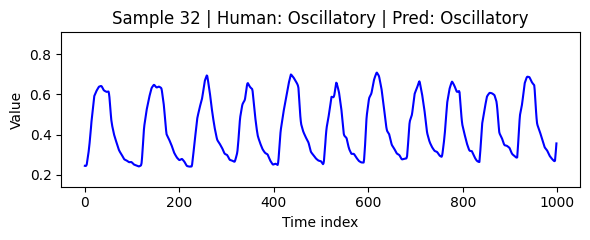

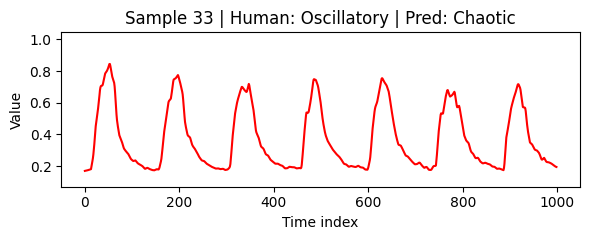

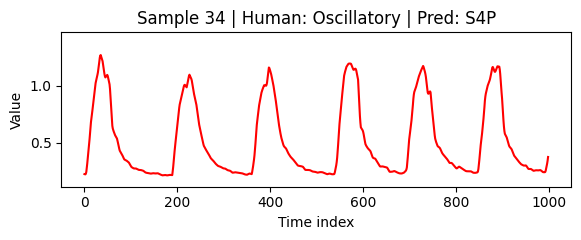

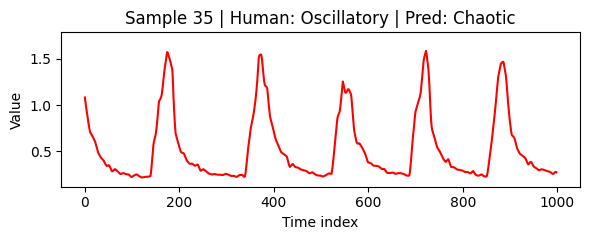

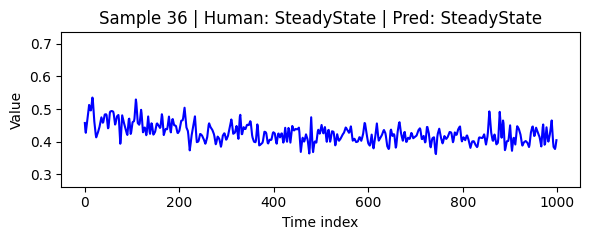

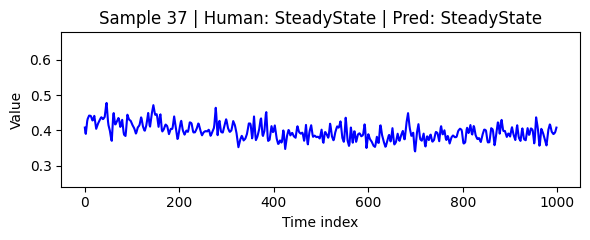

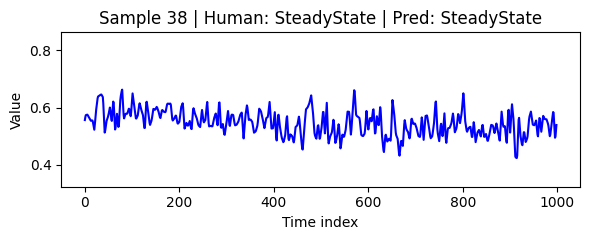

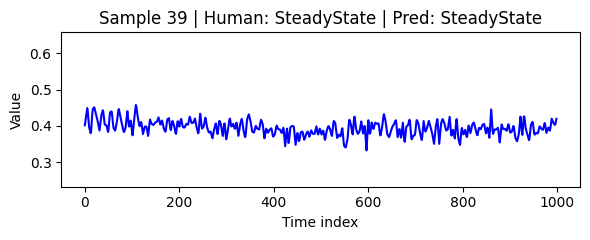

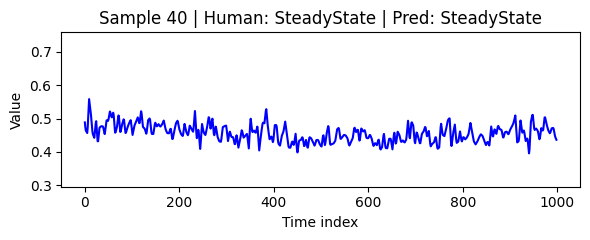

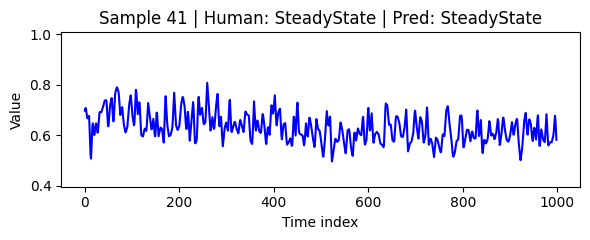

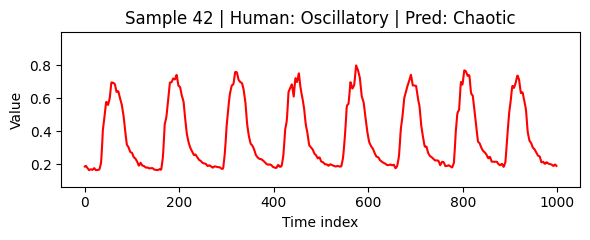

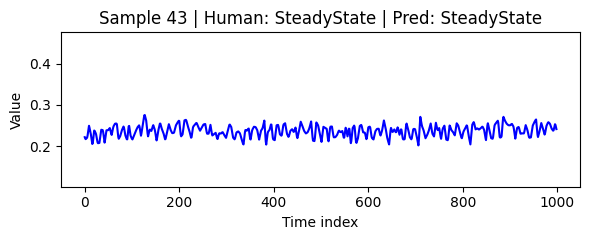

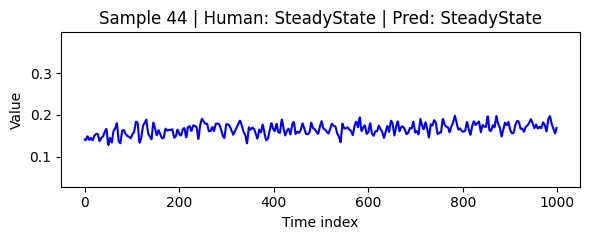

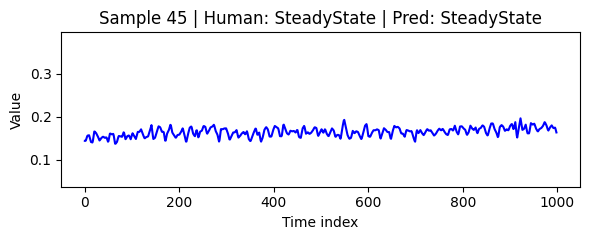

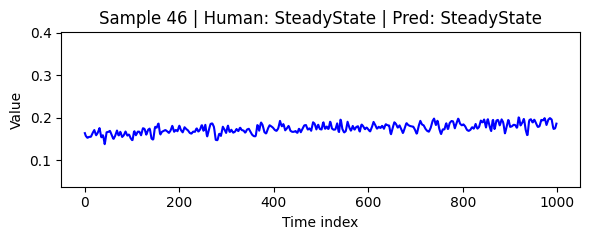

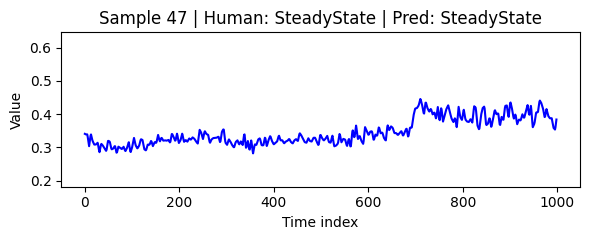

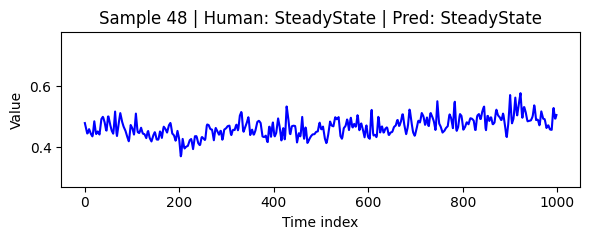

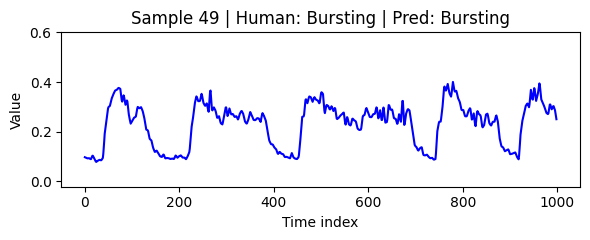

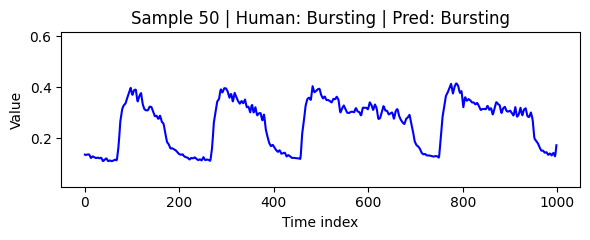

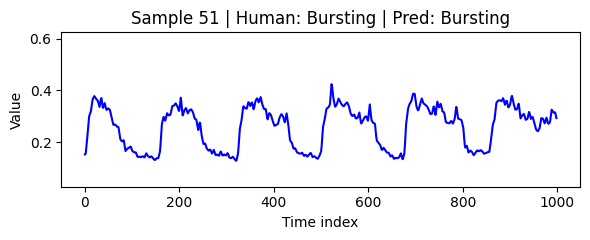

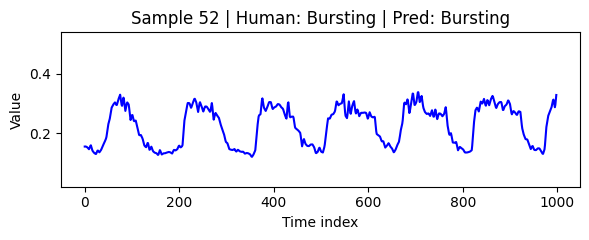

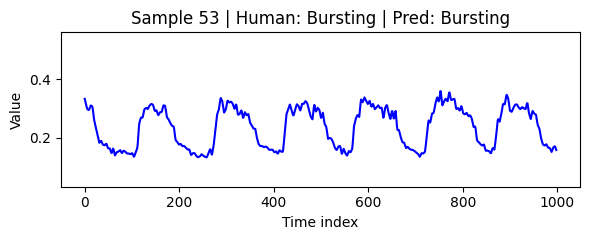

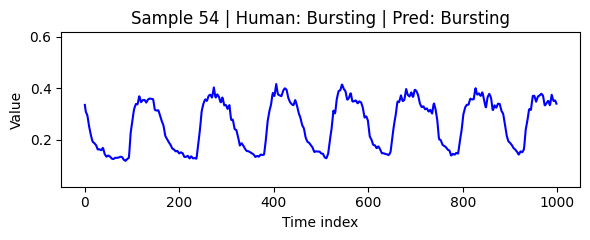

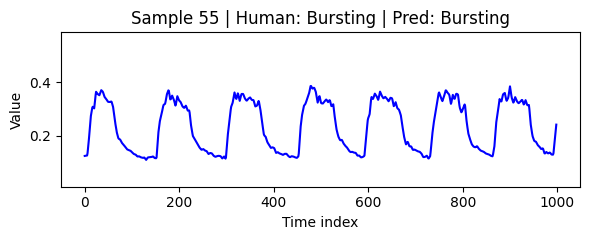

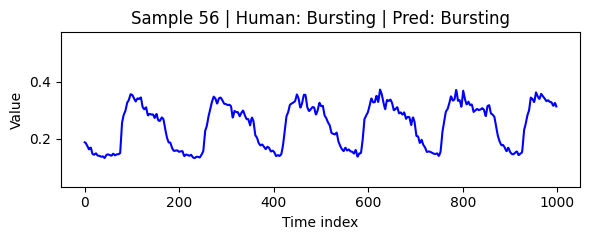

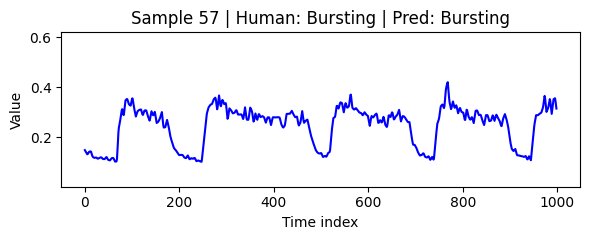

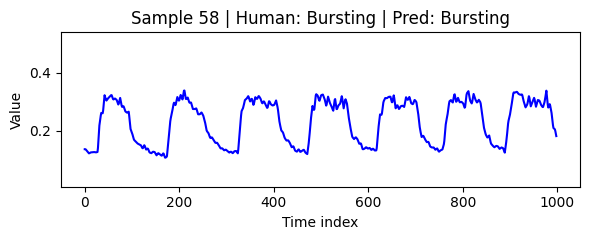

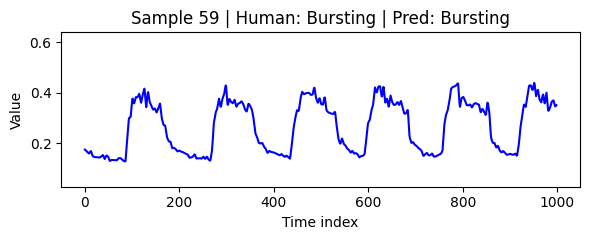

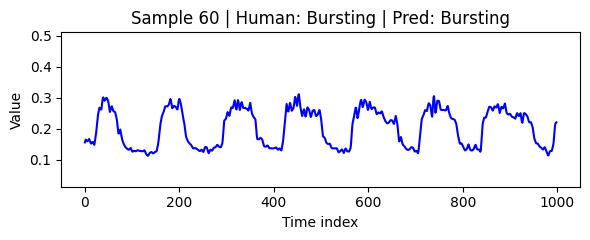

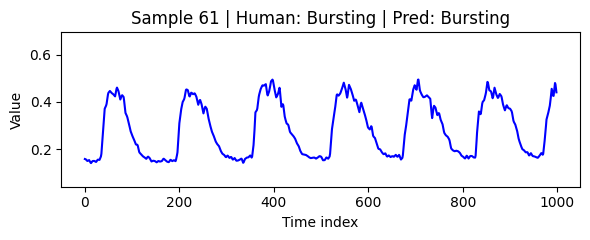

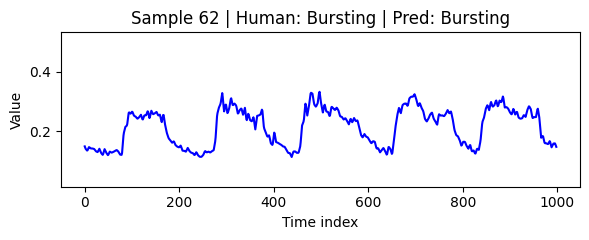

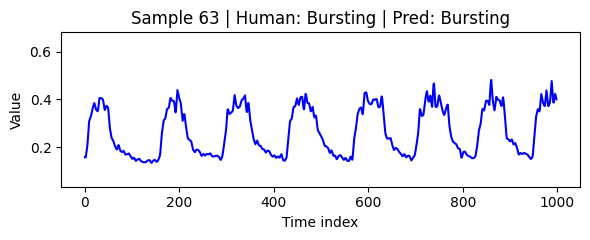

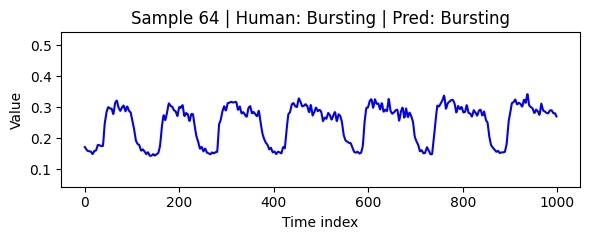

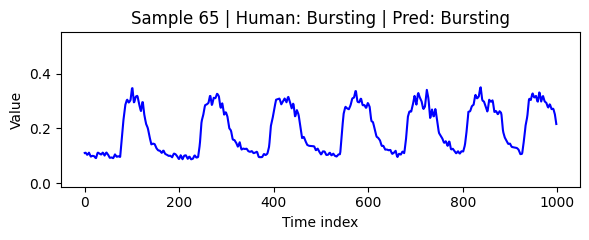

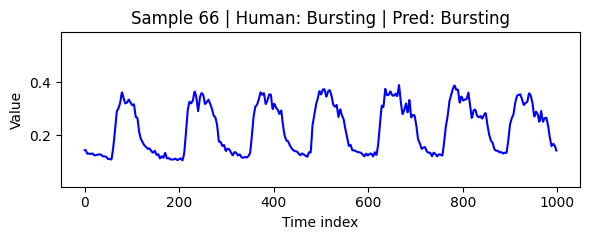

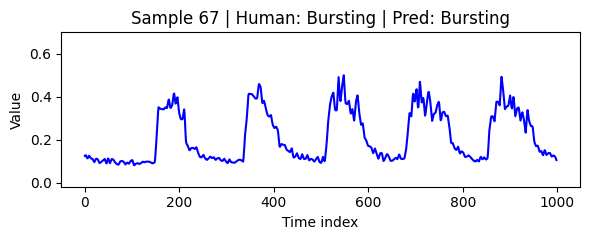

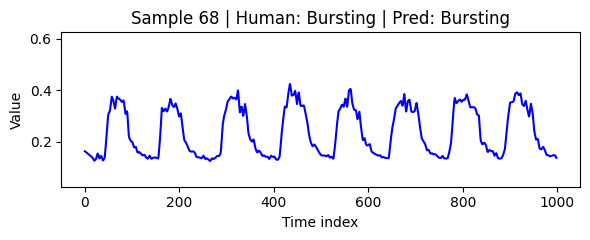

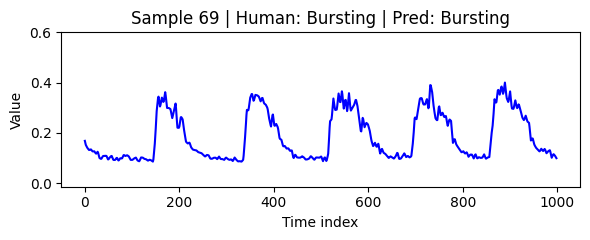

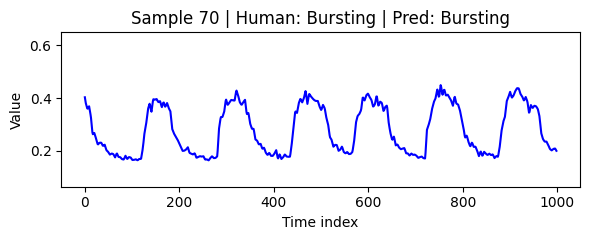

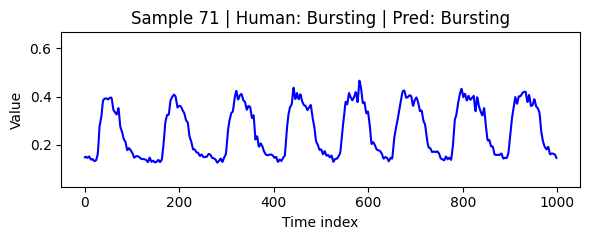

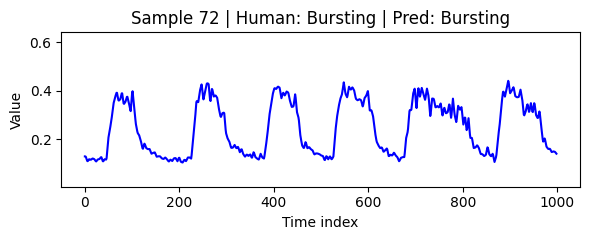

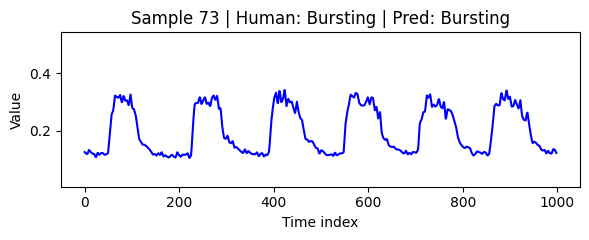

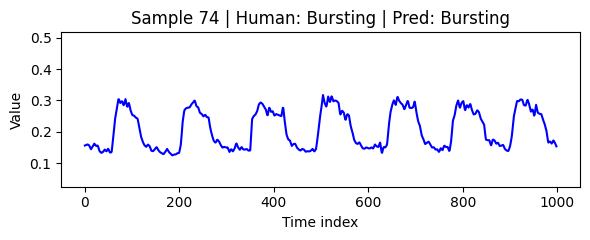

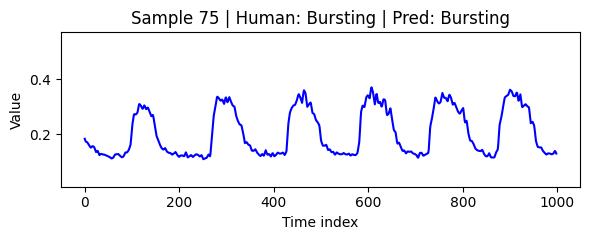

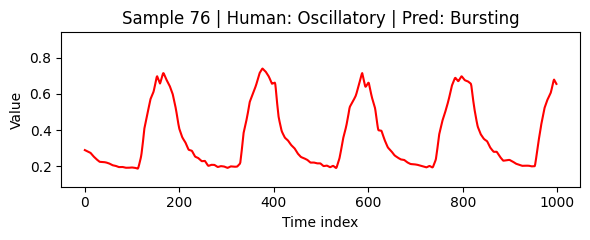

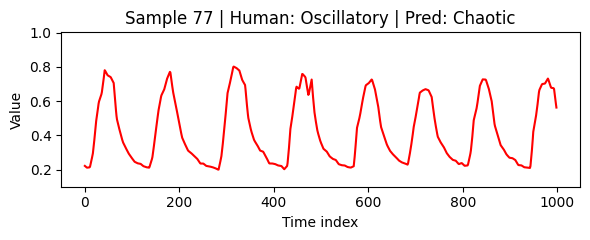

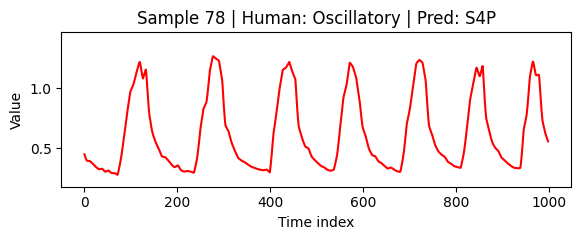

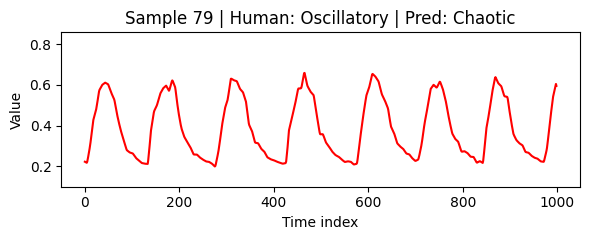

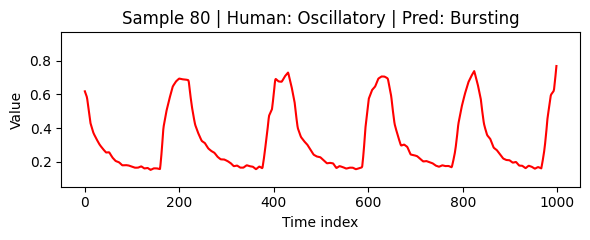

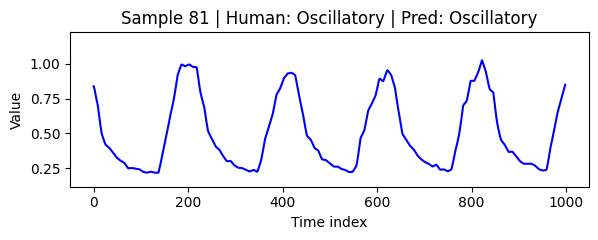

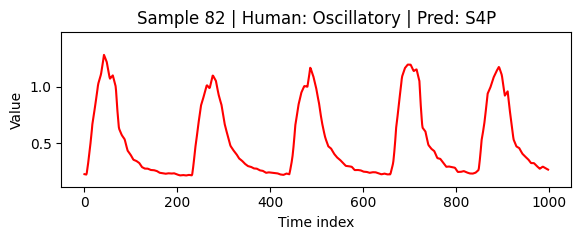

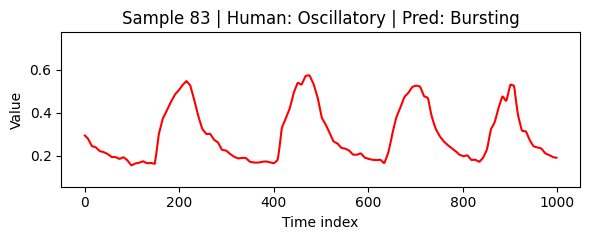

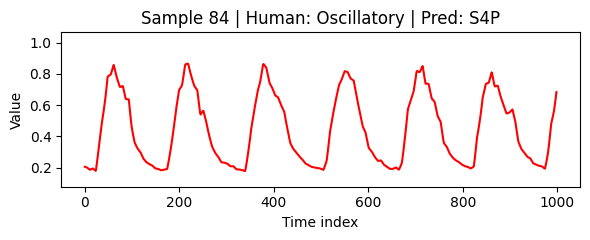

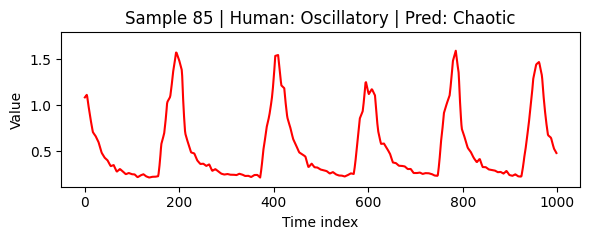

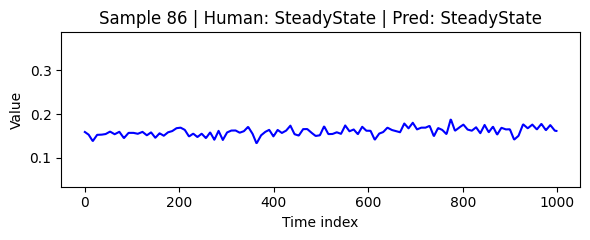

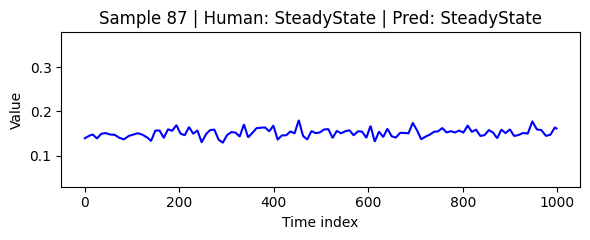

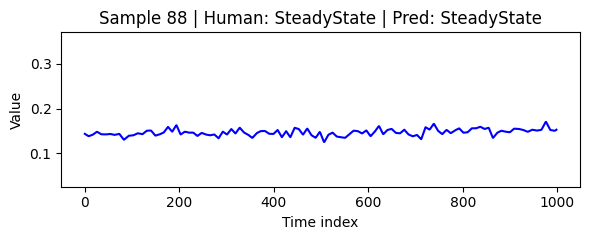

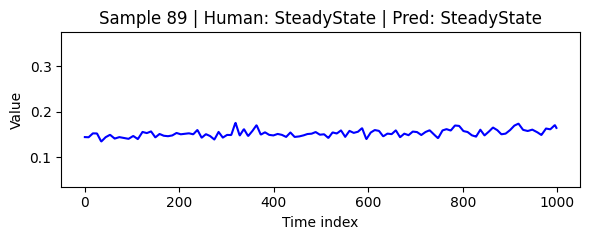

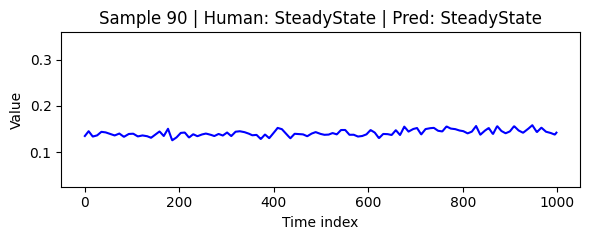

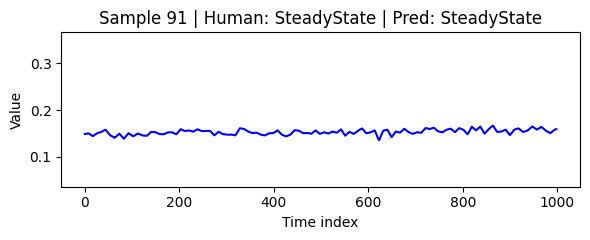

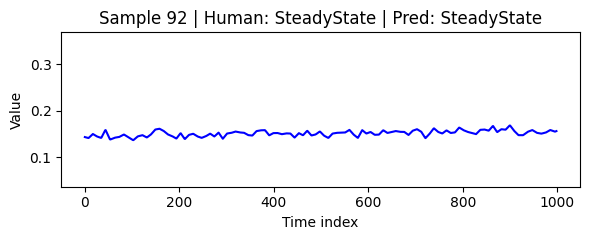

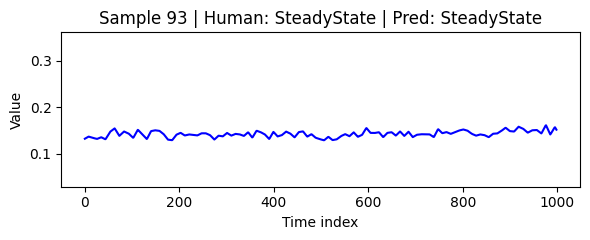

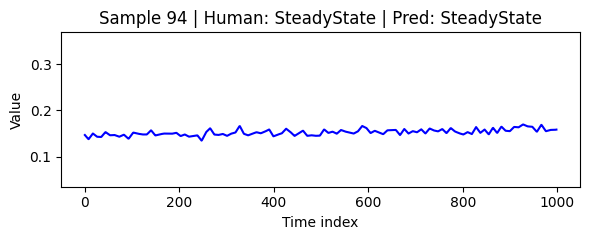

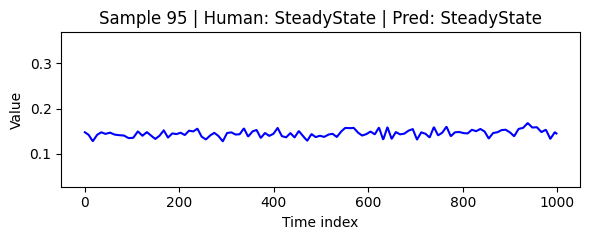

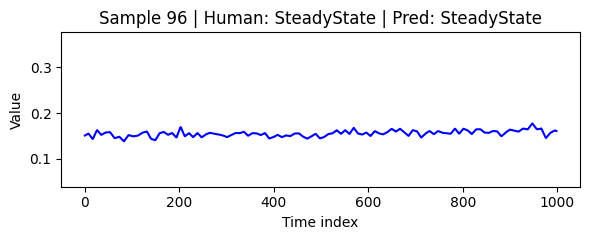

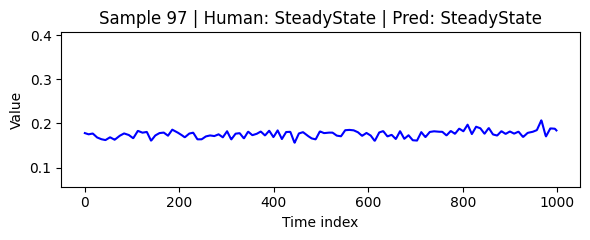

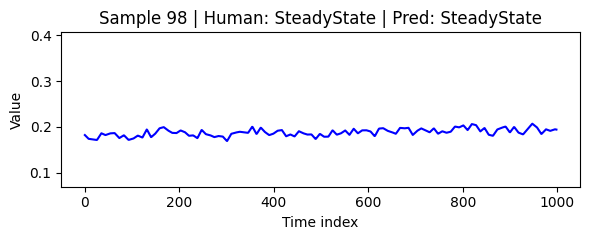

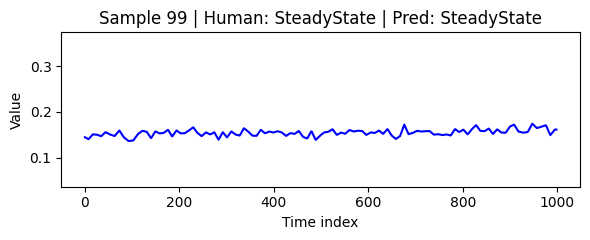

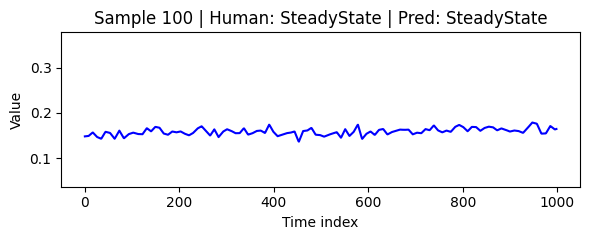

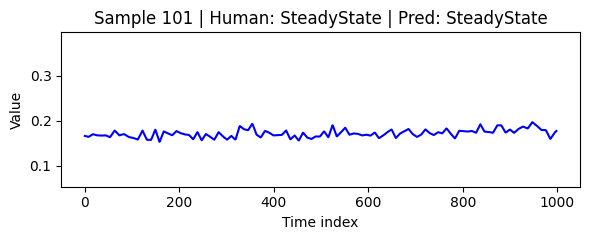

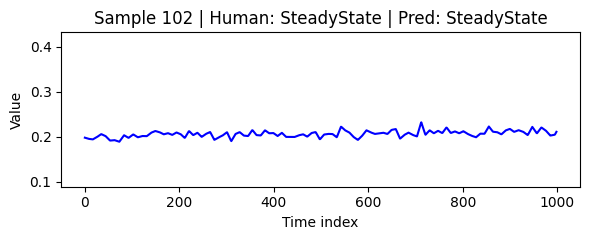

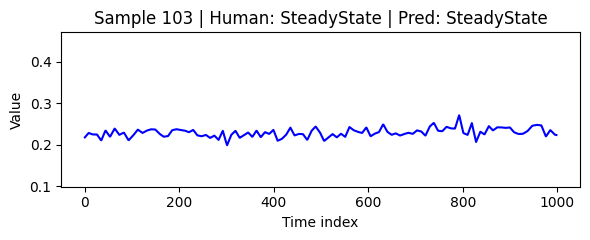

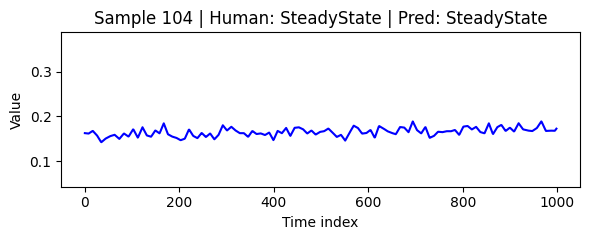

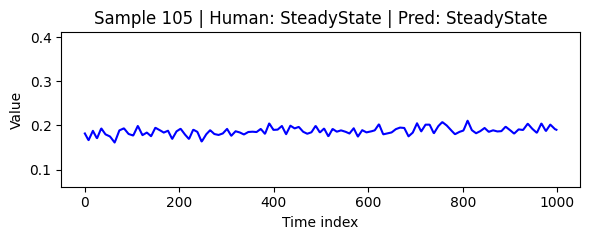

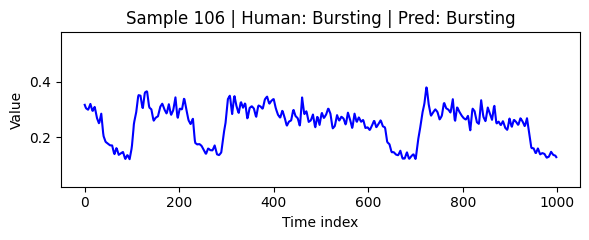

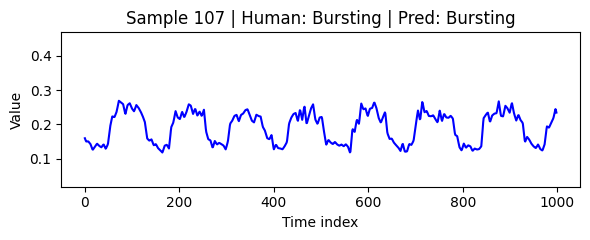

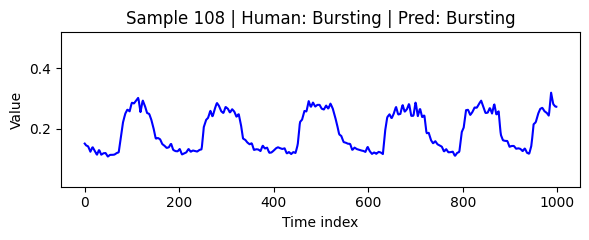

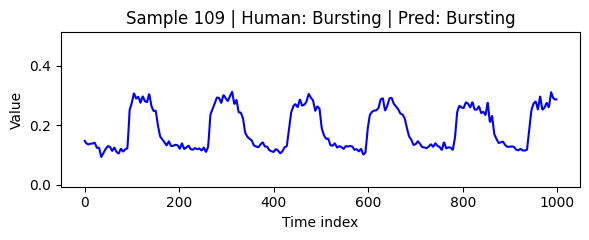

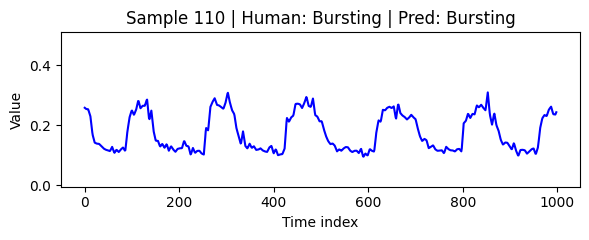

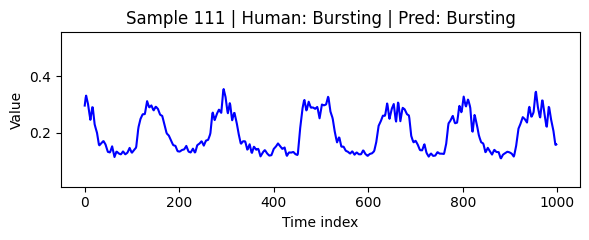

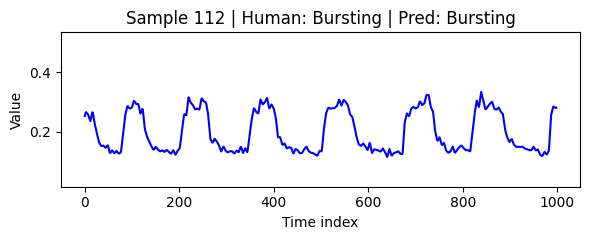

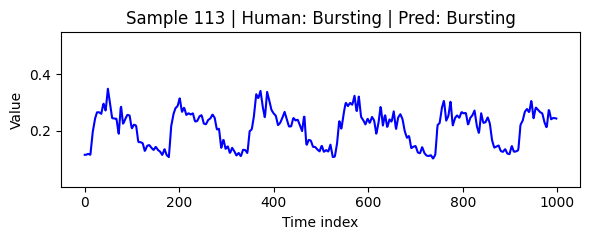

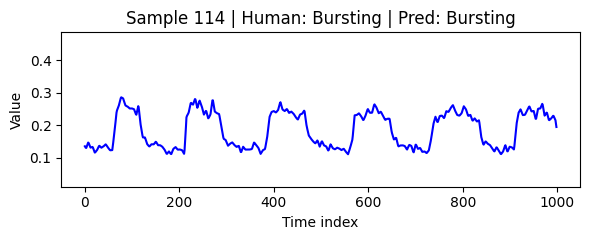

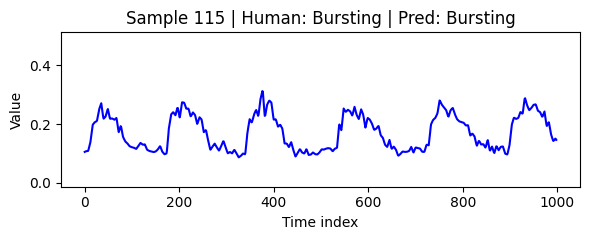

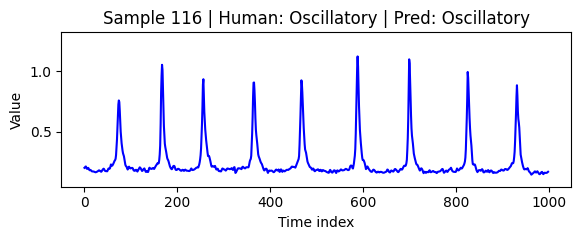

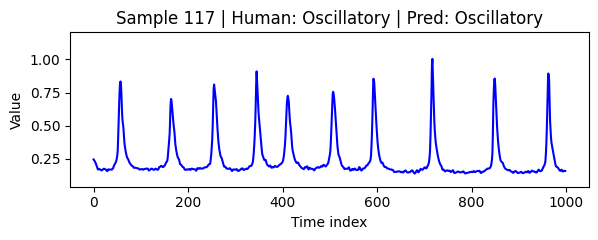

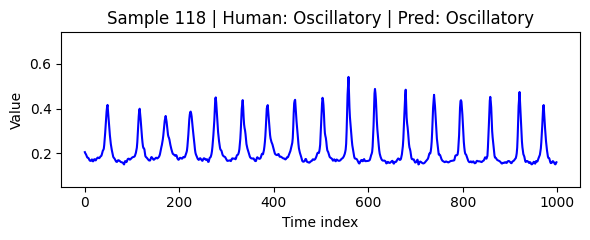

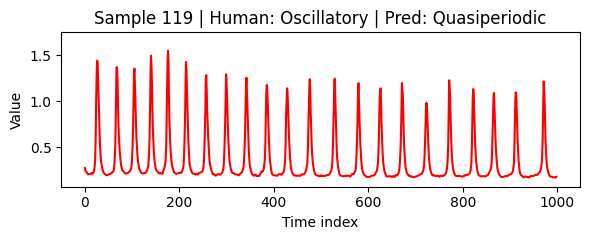

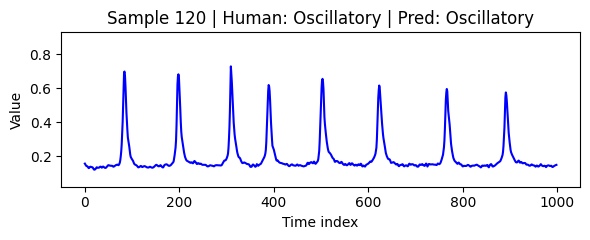

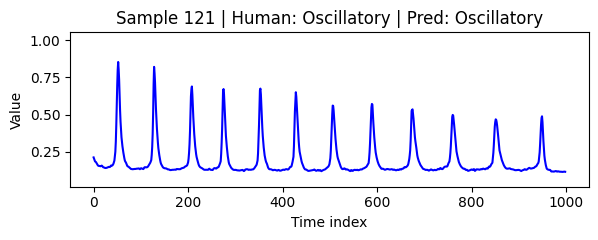

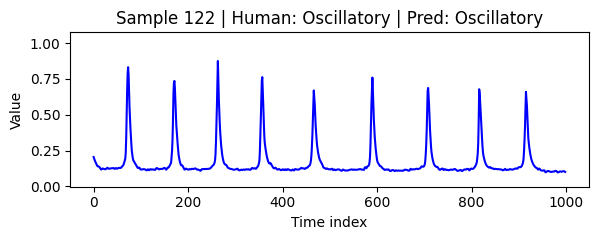

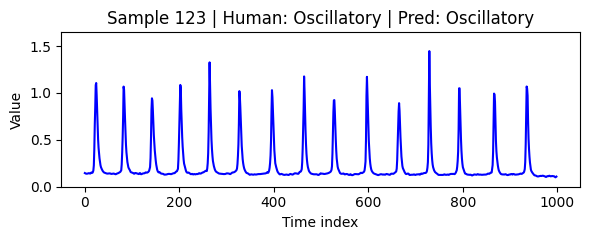

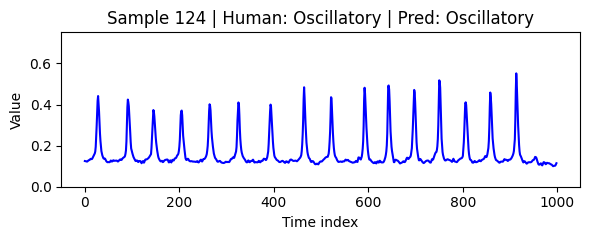

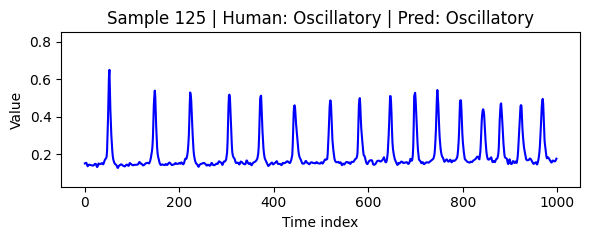

[DONE] inference and plots complete.


In [2]:
#!/usr/bin/env python
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from machines.models import Conv1DModel
from utils.data_utils import TimeSeriesDataset
from utils.parse import parse_V_set, parse_phase_diagrams
from sklearn.metrics import confusion_matrix, classification_report

def run_inference_and_plot(X_test, y_test,
                           V_train, PhaseDiagram,
                           kernel_size, seed, max_samples):
    """Load model, run prediction, and plot confidence & confusion matrix."""
    # Original class names based on the model's output
    original_class_names = [
        'Bursting', 'Chaotic', 'Oscillatory', 'Quasiperiodic',
        'S2P', 'S3P', 'S4P', 'SteadyState'
    ]

    # build path to the best checkpoint
    V_str     = parse_V_set(V_train)
    Phase_str = parse_phase_diagrams(PhaseDiagram)
    model_dir = os.path.join(
        'lkcnn_storage',
        V_str, Phase_str,
        f"kernel_{kernel_size}",
        f"seed_{seed}",
        f"max_samples_{max_samples}"
    )
    best_pt = os.path.join(model_dir, "best_model.pt")
    if not os.path.exists(best_pt):
        raise FileNotFoundError(f"Model not found: {best_pt}")

    # load model onto CPU/GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = Conv1DModel(kernel_size, X_test.shape[1], len(original_class_names)).to(device)
    model.load_state_dict(torch.load(best_pt, map_location=device))
    model.eval()

    # prepare DataLoader
    ds = TimeSeriesDataset(X_test[:, None, :], y_test)
    dl = DataLoader(ds, batch_size=32, shuffle=False)

    # collect true labels, predictions, confidences
    true_cls, pred_cls = [], []
    with torch.no_grad():
        for x, y in dl:
            logits = model(x.to(device))
            probs  = torch.softmax(logits, dim=1)
            pred   = torch.argmax(probs, dim=1)
            conf   = probs[torch.arange(len(pred)), pred]
            true_cls.extend(y.numpy())
            pred_cls.extend(pred.cpu().numpy())


    # --- Remap classes for new confusion matrix ---
    # New class structure: 0: Bursting, 1: SteadyState, 2: Others
    new_class_names = ['Bursting', 'SteadyState', 'Others']
    
    def map_label(label):
        if label == 0:  # Original 'Bursting'
            return 0
        elif label == 7: # Original 'SteadyState'
            return 1
        else: # All other classes
            return 2

    true_cls_mapped = [map_label(l) for l in true_cls]
    pred_cls_mapped = [map_label(l) for l in pred_cls]
    # -----------------------------------------------

    # Confusion matrix with 3 classes
    cm = confusion_matrix(true_cls_mapped, pred_cls_mapped, labels=list(range(len(new_class_names))))
    acc = np.trace(cm) / cm.sum() * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap='magma')
    plt.title(f"Confusion Matrix (Accuracy: {acc:.2f}%)")
    plt.xlabel("Predicted Label")
    plt.ylabel("Human Annotation")
    plt.xticks(range(len(new_class_names)), new_class_names, rotation=45, ha='right')
    plt.yticks(range(len(new_class_names)), new_class_names)
    # Add text annotations to the cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i,j] > cm.max()/2 else 'white')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Individual sample plots are now removed as requested.
    for i in range(X_test.shape[0]):
        plt.figure(figsize=(6, 2.5))
        color = 'blue' if y_test[i] == pred_cls[i] else 'red'
        plt.plot(X_test[i], color=color)
        plt.title(f"Sample {i} | Human: {original_class_names[y_test[i]]} | Pred: {original_class_names[pred_cls[i]]}")
        plt.xlabel('Time index')
        plt.ylabel('Value')
        y = X_test[i]
        lo = np.min(y) - 0.1
        hi = np.max(y) + 0.2
        plt.ylim(lo, hi)
        plt.tight_layout()
        plt.show()

def main():
    np.random.seed(0)

    df = pd.read_csv("processed_data.csv", header=0)

    if df.columns[-1] == '' or df[df.columns[-1]].isna().all():
        df = df.iloc[:, :-1]

    # Extract data and labels directly without preprocessing
    X_test = df.iloc[2:, 1:].to_numpy(dtype=np.float32).T  # shape (N, T)
    y_test = df.iloc[0, 1:].astype(np.int64).to_numpy()    # shape (N,)
    
    # --- User Defaults ---
    # These parameters are used to find the correct model checkpoint file.
    V_TRAIN         = [float('inf'), 1e8, 1e7, 1e6, 1e5]
    KERNEL_SIZE     = 28
    SEED            = 16
    PHASE_DIAGRAM   = [1, 2, 3]
    MAX_SAMPLES     = 1000
    # ---------------------

    run_inference_and_plot(
        X_test, y_test, V_TRAIN, PHASE_DIAGRAM,
        KERNEL_SIZE, SEED, MAX_SAMPLES)

    print("[DONE] inference and plots complete.")

if __name__ == "__main__":
    main()
